In [1]:
!nvidia-smi

Mon Sep 13 23:39:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P0    34W / 200W |    315MiB /  7973MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.manifold import TSNE
# from jacobian import JacobianReg
from sklearn.cluster import KMeans

In [3]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"

CUDA is available!


In [4]:
train_image_path = "/home/max/Desktop/galaxy_image/three_final/train/"
val_image_path = "/home/max/Desktop/galaxy_image/three_final/validation/"
test_image_path = "/home/max/Desktop/galaxy_image/three_final/test/"

In [5]:
batch_size = 70
train_trans = transforms.Compose([
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomRotation((-30, 30)),
#                                   transforms.Resize((255, 255)),
#                                   transforms.CenterCrop(210),
                                  transforms.Resize((255, 255)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                                  transforms.ToTensor()])

train_data = ImageFolder(train_image_path, transform = train_trans)
train_loader = DataLoader(train_data, pin_memory = True, batch_size = batch_size, sampler=ImbalancedDatasetSampler(train_data))

val_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
val_data = ImageFolder(val_image_path, transform = val_trans)
val_loader = DataLoader(val_data, shuffle = True, batch_size=batch_size)

test_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data, shuffle = True, batch_size=batch_size)

print('Train:', len(train_data))
print('Valid:', len(val_data))
print('Test:', len(test_data))

Train: 2468
Valid: 100
Test: 100


In [6]:
test_img, test_lab = next(iter(test_loader))

for i in np.arange(3):
    print(test_img[i])

tensor([[[0.0980, 0.0000, 0.0000,  ..., 0.2314, 0.0000, 0.0000],
         [0.0235, 0.0392, 0.0000,  ..., 0.1294, 0.0000, 0.1765],
         [0.0000, 0.0980, 0.0000,  ..., 0.1804, 0.1333, 0.0000],
         ...,
         [0.1333, 0.0000, 0.1843,  ..., 0.0000, 0.1961, 0.1451],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1569,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1059, 0.1216, 0.0000,  ..., 0.0000, 0.0000, 0.1765],
         [0.0745, 0.0000, 0.1765,  ..., 0.1333, 0.0745, 0.1137],
         [0.0000, 0.0000, 0.1765,  ..., 0.0000, 0.0863, 0.2039],
         ...,
         [0.0000, 0.1922, 0.0000,  ..., 0.2863, 0.0000, 0.0000],
         [0.1686, 0.1412, 0.0824,  ..., 0.0000, 0.1725, 0.1412],
         [0.0000, 0.0000, 0.0235,  ..., 0.1333, 0.0000, 0.1216]],

        [[0.0000, 0.1216, 0.2392,  ..., 0.0000, 0.0902, 0.0824],
         [0.1255, 0.2431, 0.0000,  ..., 0.1686, 0.0667, 0.0000],
         [0.3137, 0.2157, 0.0314,  ..., 0.0745, 0.0000, 0.

In [7]:
# 1. Input layer
# 2. Convolutional layer
# 3. ReLU layer
# 4. Pooling layer
# 5. Fully-connected layer
class Galaxy(nn.Module):
  def __init__(self):
    super(Galaxy, self).__init__()
    # input_shape = (3, 224, 224)
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
    #                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # in_channels: Input channels
    # out_channels: Output channels
    # kernel_size: Fillter size
    # stride: Each step our Fillter move
    # padding: We want our image can remain origin size
    self.cnn = nn.Sequential(
        ## CNN1
        nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), # padding = kernel_size / 2
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (64, 112, 112)
        ## CNN2
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (128, 56, 56)
        ## CNN3
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (256, 28, 28)
        ## CNN4
        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (512, 14, 14)
        ## CNN5
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)## (512, 7, 7)
        ## CNN6
#         nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size = 2)## (1024, 3, 3)
    )
    self.fc = nn.Sequential(
        nn.Linear(512 * 7 * 7, 256), # Fully-connected layer
        nn.Dropout(0.5), # Avoid overfitting
        nn.ReLU(),
        nn.Linear(256, 128),
#         nn.Dropout(0.5),
#         nn.ReLU(),
# #         nn.Linear(512, 256),
# #         nn.Dropout(0.5),
# #         nn.ReLU(),
#         nn.Linear(128, 3)
    )
    self.out = nn.Linear(128, 3)
  # forward propagation
  def forward(self, x):
    x = self.cnn(x)
    x = x.flatten(1)
    x = self.fc(x)
    output = self.out(x)
    return output, x

In [8]:
model = torch.load('E_I_S_new.pkl')

In [9]:
def plot_low_dim(low, lab):
    color = ['red', 'blue', 'yellow']
    plt.cla()
    for i in range(batch_size):
        plt.scatter(low[0][i][0], low[0][i][1], color=color[lab[0][i]])

In [10]:
low = []
label = []

In [11]:
# for test_img, test_lab in tqdm(test_loader):
test_img = test_img.to(device)
out, last = model(test_img)
out, last = out.cpu(), last.cpu()
pred_y = torch.max(out, 1)[1].data.numpy()
accuracy = float((pred_y == test_lab.data.numpy()).astype(int).sum()) / float(test_lab.size(0))
print('test accuracy: %.2f' % accuracy)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim = tsne.fit_transform(last.data.numpy())
kmeans = KMeans(n_clusters=3, random_state=0).fit(low_dim)
low.append(low_dim.tolist())
lab = test_lab.numpy().tolist()
label.append(lab)

/home/max/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


test accuracy: 0.90


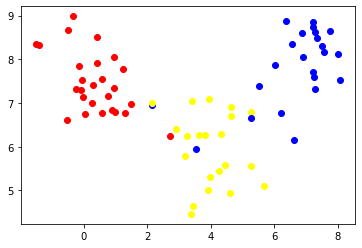

In [12]:
plot_low_dim(low, label)

In [13]:
print(kmeans)

KMeans(n_clusters=3, random_state=0)


In [14]:
y_kmeans = kmeans.predict(low_dim)

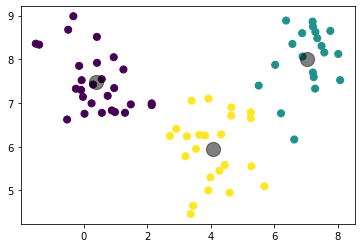

In [15]:
plt.scatter(low_dim[:, 0], low_dim[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [16]:
print(y_kmeans)

[1 1 0 0 1 0 1 2 2 0 1 0 0 0 1 2 1 2 2 1 0 0 0 0 1 0 1 2 2 0 0 2 2 0 2 1 1
 1 0 2 2 2 2 0 0 2 1 2 0 2 2 1 2 0 0 0 2 0 1 0 2 0 2 1 1 1 0 1 0 2]


In [17]:
print(label[0])

[1, 1, 0, 0, 1, 0, 1, 2, 2, 0, 1, 0, 1, 0, 1, 2, 1, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 2, 2, 0, 2, 1, 1, 1, 0, 2, 2, 2, 2, 0, 0, 2, 1, 2, 0, 0, 2, 1, 2, 0, 0, 0, 1, 0, 1, 0, 2, 2, 2, 1, 1, 1, 0, 1, 0, 2]


In [18]:
cnt = 0
for i in range(70):
    if y_kmeans[i] == label[0][i]:
        cnt+=1
print(f'k-means accuracy: {(cnt/70) * 100:.2f}%')
print(cnt)

k-means accuracy: 92.86%
65
